# **Final Project**: Lung Cancer Mortality Analytics

In [1]:
# data wrangling tools
import pandas as pd
import numpy as np


# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# statistical learning
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn import tree

! pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

! pip install shap
import shap 

import random

%matplotlib inline


## **Part 0: Loading the libraries and the data**


In this project, we want to develop a statistical model for the mortality rate of lung cancer in the United States.

One of the parts overlooked in many machine learning projects is preprocessing. And a good way to learn it is by solving a lot of examples and test cases. A big part of this project is walking you through preprocessing, making informed decisions using your observations, and exploratory data analysis. Then we use supervised learning methods to construct models to predict the mortality rate of lung cancer using the features provided here.


## Loading data
Load the three csv files as pandas dataframes directly from their URLs.

In [2]:
fulldf = pd.read_csv('mydata.csv').drop(columns='Unnamed: 0')
data_dict = pd.read_csv('descriptions.csv')
populationdf = pd.read_csv('populations.csv').drop(columns='Unnamed: 0')

Dataset `mydata.csv` includes majority of the data. 

Dataset `populations.csv` includes population data by county.

Explanations on the meaning of each of the columns are included in `descriptions.csv`.

In [3]:
data_dict

,Unnamed: 0,Feature,Definition,Notes
0,0,State,NaN,NaN
1,1,AreaName,NaN,NaN
2,2,All_Poverty,Both male and female reported below poverty li...,NaN
3,3,M_Poverty,Males below poverty (Raw),NaN
4,4,F_Poverty,Females below poverty (Raw),NaN
5,5,FIPS,State + County FIPS (Raw),NaN
6,6,Med_Income,Med_Income all enthnicities (Raw),NaN
7,7,Med_Income_White,Med_Income white (Raw),NaN
8,8,Med_Income_Black,Med_Income black (Raw),NaN
9,9,Med_Income_Nat_Am,Med_Income native American (Raw),NaN


In [4]:
print(fulldf.info())
fulldf.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3134 entries, 0 to 3133
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   State                3134 non-null   object 
 1   AreaName             3134 non-null   object 
 2   All_Poverty          3134 non-null   int64  
 3   M_Poverty            3134 non-null   int64  
 4   F_Poverty            3134 non-null   int64  
 5   FIPS                 3134 non-null   int64  
 6   Med_Income           3133 non-null   float64
 7   Med_Income_White     3132 non-null   float64
 8   Med_Income_Black     1924 non-null   float64
 9   Med_Income_Nat_Am    1474 non-null   float64
 10  Med_Income_Asian     1377 non-null   float64
 11  Med_Income_Hispanic  2453 non-null   float64
 12  M_With               3134 non-null   int64  
 13  M_Without            3134 non-null   int64  
 14  F_With               3134 non-null   int64  
 15  F_Without            3134 non-null   i

,State,AreaName,All_Poverty,M_Poverty,F_Poverty,FIPS,Med_Income,Med_Income_White,Med_Income_Black,Med_Income_Nat_Am,...,M_Without,F_With,F_Without,All_With,All_Without,Incidence_Rate,Avg_Ann_Incidence,Recent_Trend,Mortality_Rate,Avg_Ann_Deaths
1083,KY,"Perry County, Kentucky",6894,2903,3991,21193,32667.0,31911.0,93000.0,NaN,...,1921,11982,1944,23526,3865,139.7,49,falling,125.6,43
1411,MO,"Carroll County, Missouri",1273,555,718,29033,42415.0,43854.0,NaN,NaN,...,437,4094,549,8016,986,94.6,13,stable,63.4,9
2609,TX,"Guadalupe County, Texas",13924,5939,7985,48187,62420.0,63571.0,64646.0,55726.0,...,10828,61380,10367,120040,21195,58.6,80,stable,41.6,56
876,IN,"Warrick County, Indiana",5926,2551,3375,18173,62185.0,62256.0,49500.0,23830.0,...,2520,28236,2148,55586,4668,66.7,47,stable,46.7,32
1240,MI,"Cheboygan County, Michigan",4595,2023,2572,26031,40219.0,40860.0,65000.0,34583.0,...,1840,11273,1519,22028,3359,73.6 #,32,stable,62.7,27
2776,UT,"Duchesne County, Utah",2019,821,1198,49013,61133.0,61377.0,NaN,45417.0,...,1519,8101,1535,16393,3054,50.2,8,stable,34.9,6
567,IA,"Clinton County, Iowa",6608,2840,3768,19045,50498.0,52613.0,19125.0,NaN,...,1640,22956,1284,44946,2924,64.1,42,stable,50.5,33
682,ID,"Power County, Idaho",1034,353,681,16077,44779.0,43551.0,NaN,56186.0,...,471,3203,596,6599,1067,41.4,3,*,*,*
1045,KY,"Kenton County, Kentucky",23432,10164,13268,21117,54296.0,56285.0,24928.0,18688.0,...,8846,74031,7822,144789,16668,90.3,145,stable,65,102
1847,NE,"Howard County, Nebraska",658,333,325,31093,50030.0,50476.0,NaN,NaN,...,238,2953,140,5949,378,54.1,5,stable,43.2,4


In [5]:
print(populationdf.info())
populationdf.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3193 entries, 0 to 3192
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   POPESTIMATE2015  3193 non-null   int64
 1   STATE            3193 non-null   int64
 2   COUNTY           3193 non-null   int64
dtypes: int64(3)
memory usage: 75.0 KB
None


,POPESTIMATE2015,STATE,COUNTY
476,13635,13,159
646,28672,17,75
375,198664,12,91
83,18433,5,1
206,150965,6,31
387,405549,12,115
2908,1982498,48,439
480,9656,13,167
2395,1680,41,55
2489,56194,45,21


## **Part 1: Getting started**

## Data cleaning


### 1.1 Convert `FIPS` column to correct format
Federal Information Processing Standard or [FIPS](https://en.wikipedia.org/wiki/FIPS_county_code) is a categorical variable. It is a code with five digits. The left two digits showing the state and the three right digits showing the county code. We recognize that desipite being a number, FIPS is actually a categorical variable.


In [6]:
#Convert FIPS values to 'object'
fulldf.FIPS = fulldf.FIPS.astype(str)

#Reformat FIPS values to standard
fulldf.FIPS = fulldf.FIPS.str.pad(width=5,side='left',fillchar='0')
print(fulldf.FIPS.sample())

2813    51031
Name: FIPS, dtype: object


### 1.2 Check for null values [5 Marks]

Just check for null values and remove columns whenever the percentage of null values is greater than 20. 

In [7]:
#Count null values for each column
null_vals = fulldf.isnull().sum() 

#Calculate percentage of null values for each column
null_per = round((null_vals/fulldf.shape[0])*100,2)
print(null_per)

State                   0.00
AreaName                0.00
All_Poverty             0.00
M_Poverty               0.00
F_Poverty               0.00
FIPS                    0.00
Med_Income              0.03
Med_Income_White        0.06
Med_Income_Black       38.61
Med_Income_Nat_Am      52.97
Med_Income_Asian       56.06
Med_Income_Hispanic    21.73
M_With                  0.00
M_Without               0.00
F_With                  0.00
F_Without               0.00
All_With                0.00
All_Without             0.00
Incidence_Rate          0.00
Avg_Ann_Incidence       0.00
Recent_Trend            0.00
Mortality_Rate          0.00
Avg_Ann_Deaths          0.00
dtype: float64


Most race-based median income features have more than 20% values missing. This is understandable since minorities seems to be under-accounted for in many US reports. We decide to remove those columns because these could lead to racial bias if we buid a model based on them. Med_Income_White is also removed to protect racial equality even though most of its data are available.

In [8]:
#Drop racial income columns
nonnulldf = fulldf.drop(['Med_Income_White','Med_Income_Black','Med_Income_Nat_Am','Med_Income_Asian','Med_Income_Hispanic'],axis=1)

print('The remaining columns are:')
for i in pd.Series(nonnulldf.columns):
    print(i)

The remaining columns are:
State
AreaName
All_Poverty
M_Poverty
F_Poverty
FIPS
Med_Income
M_With
M_Without
F_With
F_Without
All_With
All_Without
Incidence_Rate
Avg_Ann_Incidence
Recent_Trend
Mortality_Rate
Avg_Ann_Deaths


### 1.3 Check the format of columns [5 Marks]

In [9]:
nonnulldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3134 entries, 0 to 3133
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   State              3134 non-null   object 
 1   AreaName           3134 non-null   object 
 2   All_Poverty        3134 non-null   int64  
 3   M_Poverty          3134 non-null   int64  
 4   F_Poverty          3134 non-null   int64  
 5   FIPS               3134 non-null   object 
 6   Med_Income         3133 non-null   float64
 7   M_With             3134 non-null   int64  
 8   M_Without          3134 non-null   int64  
 9   F_With             3134 non-null   int64  
 10  F_Without          3134 non-null   int64  
 11  All_With           3134 non-null   int64  
 12  All_Without        3134 non-null   int64  
 13  Incidence_Rate     3134 non-null   object 
 14  Avg_Ann_Incidence  3134 non-null   object 
 15  Recent_Trend       3134 non-null   object 
 16  Mortality_Rate     3134 

In [10]:
#Identify columns that cannot be reformatted to 'float' type
column_list = {'Incidence_Rate', 'Avg_Ann_Incidence', 'Recent_Trend', 'Mortality_Rate', 'Avg_Ann_Deaths'}
for col in column_list:
    try:
        fulldf[col] = fulldf[col].astype(float)
    except ValueError as e:
        print(f'{col} cannot be reformatted to the correct format.')

Avg_Ann_Deaths cannot be reformatted to the correct format.
Mortality_Rate cannot be reformatted to the correct format.
Incidence_Rate cannot be reformatted to the correct format.
Recent_Trend cannot be reformatted to the correct format.
Avg_Ann_Incidence cannot be reformatted to the correct format.


In [11]:
for col in column_list:
  print(f'{col} has the following unique values: {sorted(fulldf[col].unique())}')
  print('\n')

Avg_Ann_Deaths has the following unique values: ['*', '1,097', '1,136', '1,243', '1,463', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '126', '127', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '142', '143', '144', '145', '146', '148', '15', '150', '151', '152', '154', '156', '157', '159', '16', '162', '163', '164', '165', '167', '168', '169', '17', '170', '171', '172', '174', '175', '176', '177', '178', '179', '18', '181', '182', '183', '185', '186', '187', '189', '19', '191', '193', '194', '196', '198', '199', '2,369', '2,876', '20', '200', '201', '202', '204', '206', '207', '21', '210', '211', '213', '216', '219', '22', '221', '223', '227', '23', '230', '232', '233', '236', '24', '240', '241', '242', '245', '247', '249', '25', '250', '251', '254', '257', '258', '26', '262', '263', '268', '27', 

These features cannot be reformated because they may have non-numerical values that represents missing or error data. 

### 1.4 Merge the population data to the main dataframe 

In [12]:
print(populationdf.info())
print(populationdf.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3193 entries, 0 to 3192
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   POPESTIMATE2015  3193 non-null   int64
 1   STATE            3193 non-null   int64
 2   COUNTY           3193 non-null   int64
dtypes: int64(3)
memory usage: 75.0 KB
None
      POPESTIMATE2015  STATE  COUNTY
660             34584     17     103
1553            10139     29      89
2735            13430     48      93
2276           375165     39     151
2596            14502     47       7
2842             8341     48     307
1477            11043     28     103
2010            14434     37     173
2405           102295     42       1
3011             5211     51      45


In [13]:
#Reformat and create FIPS column
populationdf.STATE = populationdf.STATE.astype(str)
populationdf.STATE = populationdf.STATE.str.pad(width=2,side='left',fillchar='0')
populationdf.COUNTY = populationdf.COUNTY.astype(str)
populationdf.COUNTY = populationdf.COUNTY.str.pad(width=3,side='left',fillchar='0')
populationdf['FIPS'] = populationdf.STATE + populationdf.COUNTY
print(populationdf.sample(10))

      POPESTIMATE2015 STATE COUNTY   FIPS
2508            66623    45    059  45059
2734           129048    48    091  48091
1043            14375    21    065  21065
1500            47485    28    149  28149
1457             7507    28    063  28063
373             77482    12    087  12087
1828             3456    35    003  35003
547             20816    13    303  13303
1715            21900    31    067  31067
224           1501335    06    067  06067


In [14]:
#Merge datasets
fullpopdf = nonnulldf.set_index('FIPS').join(populationdf.set_index('FIPS')).drop(['STATE','COUNTY'],axis=1)
fullpopdf = fullpopdf.reset_index()
print(fullpopdf.sample(10))

       FIPS State                        AreaName  All_Poverty  M_Poverty  \
1845  31089    NE           Holt County, Nebraska         1209        512   
604   19119    IA               Lyon County, Iowa          843        404   
2510  47179    TN    Washington County, Tennessee        21842       9588   
1586  28153    MS       Wayne County, Mississippi         5509       2334   
2947  53005    WA       Benton County, Washington        26013      11805   
1896  33005    NH  Cheshire County, New Hampshire         8467       3684   
2928  51820    VA       Waynesboro city, Virginia         3796       1496   
1268  26087    MI         Lapeer County, Michigan         9152       4261   
2718  48405    TX     San Augustine County, Texas         2105        978   
2754  48477    TX        Washington County, Texas         4325       1895   

      F_Poverty  Med_Income  M_With  M_Without  F_With  F_Without  All_With  \
1845        697     46728.0    4599        482    4691        461      92

### 1.5 Cleaning the output (response) column `Mortality_Rate`

In [15]:
data_dict

,Unnamed: 0,Feature,Definition,Notes
0,0,State,NaN,NaN
1,1,AreaName,NaN,NaN
2,2,All_Poverty,Both male and female reported below poverty li...,NaN
3,3,M_Poverty,Males below poverty (Raw),NaN
4,4,F_Poverty,Females below poverty (Raw),NaN
5,5,FIPS,State + County FIPS (Raw),NaN
6,6,Med_Income,Med_Income all enthnicities (Raw),NaN
7,7,Med_Income_White,Med_Income white (Raw),NaN
8,8,Med_Income_Black,Med_Income black (Raw),NaN
9,9,Med_Income_Nat_Am,Med_Income native American (Raw),NaN


The non-numerical values of Mortality_Rate mean that we have fewer than 16 reported cases of lung cancer mortality per 100,000 people. 

In [16]:
df = fullpopdf.loc[:, ['Incidence_Rate', 'Avg_Ann_Incidence', 'Mortality_Rate', 'Avg_Ann_Deaths', 'POPESTIMATE2015']]
df.sample(10)

,Incidence_Rate,Avg_Ann_Incidence,Mortality_Rate,Avg_Ann_Deaths,POPESTIMATE2015
1577,81.1,13,67.1,11,14588
2627,66,29,49,22,36223
2082,70.7,40,60,34,45386
3017,64.2,20,50.4,16,19223
237,68.1,44,55.3,35,74492
1340,_,_,36.9,8,15837
1628,66.3,6,40.4,3,6184
2847,60.8,11,48.2,9,16269
967,_,_,*,*,4964
959,_,_,51.4,45,63718


In [17]:
fullpopdf[fullpopdf['State'] == 'MN'].loc[:,['State','Incidence_Rate',	'Avg_Ann_Incidence',	'Recent_Trend',	'Mortality_Rate','Avg_Ann_Deaths',	'POPESTIMATE2015']]

,State,Incidence_Rate,Avg_Ann_Incidence,Recent_Trend,Mortality_Rate,Avg_Ann_Deaths,POPESTIMATE2015
1308,MN,_,_,_,40.3,13,15702
1309,MN,_,_,_,48.4,145,344151
1310,MN,_,_,_,46.1,21,33386
1311,MN,_,_,_,41.3,20,45672
1312,MN,_,_,_,38.8,15,39710
...,...,...,...,...,...,...,...
1390,MN,_,_,_,46.5,8,10952
1391,MN,_,_,_,*,*,6396
1392,MN,_,_,_,37.8,22,50885
1393,MN,_,_,_,42.5,44,131311


In [18]:
fullpopdf[fullpopdf['State'] == 'NV'].loc[:,['State','Incidence_Rate',	'Avg_Ann_Incidence',	'Recent_Trend',	'Mortality_Rate','Avg_Ann_Deaths',	'POPESTIMATE2015']]

,State,Incidence_Rate,Avg_Ann_Incidence,Recent_Trend,Mortality_Rate,Avg_Ann_Deaths,POPESTIMATE2015
1958,NV,__,__,__,59.9,18,24200
1959,NV,__,__,__,48.1,901,2114801
1960,NV,__,__,__,40.9,32,47710
1961,NV,__,__,__,39.9,15,51935
1962,NV,__,__,__,*,*,829
1963,NV,__,__,__,*,*,2016
1964,NV,__,__,__,48.4,7,17019
1965,NV,__,__,__,*,*,5903
1966,NV,__,__,__,*,*,5036
1967,NV,__,__,__,61.2,41,52585


In [19]:
fullpopdf[fullpopdf['State'] == 'KS'].loc[:,['State','Incidence_Rate',	'Avg_Ann_Incidence',	'Recent_Trend',	'Mortality_Rate','Avg_Ann_Deaths',	'POPESTIMATE2015']]

,State,Incidence_Rate,Avg_Ann_Incidence,Recent_Trend,Mortality_Rate,Avg_Ann_Deaths,POPESTIMATE2015
882,KS,_,_,_,52.2,10,12717
883,KS,_,_,_,50.6,6,7808
884,KS,_,_,_,51.1,10,16398
885,KS,_,_,_,56,4,4823
886,KS,_,_,_,45.5,17,27103
...,...,...,...,...,...,...,...
982,KS,_,_,_,42.7,4,5598
983,KS,_,_,_,*,*,2157
984,KS,_,_,_,36.5,5,8856
985,KS,_,_,_,75.6,4,3115


We are going to do some data inspection to determine what we should do with those non-numerical values of mortality rate. First, we examine the data and find that there are systemic errors for data input for three states - Kansas, Nevada, and Minnesota for incidence rate. Specifically, there are no values for this column for these states. There for, we are going to drop those rows.

Next, we are going to examine the remaining rows that have non-numerical values for rate of mortality. 

In [20]:
print((df[df["Mortality_Rate"] == "*"]).sample(10))

     Incidence_Rate Avg_Ann_Incidence Mortality_Rate Avg_Ann_Deaths  \
3023           80.9                 4              *              *   
930               _                 _              *              *   
243              44                 4              *              *   
2783           25.8                 4              *              *   
932               _                 _              *              *   
2384              *        3 or fewer              *              *   
1645              *        3 or fewer              *              *   
2154           76.8                 4              *              *   
278               *        3 or fewer              *              *   
1750           59.4                 4              *              *   

      POPESTIMATE2015  
3023             4573  
930              2564  
243              5830  
2783            12645  
932              1670  
2384             3348  
1645             2110  
2154             3754  
27

Non-numerical values for mortality rate can be due to the fact that there are actually really low number of cases or there are mistakes with data input. 

We consider assigning 0 to those missing values. However, mortality rates depends on the population of the county. If we assigned those values to 0 because fewer than 16 cases are ported, we intentionally disregard the population of the county. Therefore, mortality rate will not be accurate. Mortality rate can still be high given the low number of deaths within that county.

To give an example, when we do a rough calculation of index 2591, we found that only 2 people died but the mortality rate is 46% given that the town population is 3827. This proves that even when there are low cases, the mortality rate can be significant different from 0. 

We have no reasonable numbers to assign to this column because at this point, we are not statistically confident that there is a correlation between incidence rate/annual incidence and mortality rate. Therefore, we decide to drop those rows.



We have a normal distribution after dropping those rows. 

<AxesSubplot:>

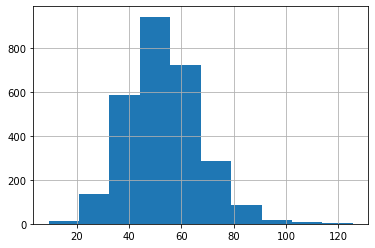

In [21]:
#Drop method

dropped = fullpopdf.copy() 

for i, r in dropped.iterrows():
    if r.Mortality_Rate == '*' :
        dropped = dropped.drop(i, axis =0)

    

sorted(dropped.Mortality_Rate.unique())
dropped.Mortality_Rate.astype(float).hist()
#dropped[dropped.Mortality_Rate == '*']  

### 1.6 Reformat the rest of the columns specified in 1.3 to numerical

Based on unique values output, some data of the Incidence_Rate feature has character '#' at the end, which we assume to be error. We will eliminate '#', which should allow us to reformat the feature to the more appropriate form.

In [22]:
fullpopdf[fullpopdf['State'] == 'MI'].loc[:,['State','Incidence_Rate']].sample(10)

,State,Incidence_Rate
1244,MI,73 #
1306,MI,83
1307,MI,90.7 #
1274,MI,75.2
1250,MI,79 #
1252,MI,66.4 #
1290,MI,71.1 #
1269,MI,35.7 #
1276,MI,64.9 #
1242,MI,75.6 #


In [23]:
#Reformat 'Incident Rate' values that inclue '#' values (mostly for Michigan)
for i, r in dropped.iterrows():
    splitted = r.Incidence_Rate.split()
    dropped.loc[i, 'Incidence_Rate'] = splitted[0]

We are going to reformat the trend column so we can perform the regression. 
For rows that contain * for trend column, we will assign 'stable' to those rows. The reason for that is when we look at the trend based on the states, we find that the majority of the trend is 'stable' for every states that have missing values for trend. Therefore, we will assume that those missing values are 'stable'. We do not want to remove those rows because we want to keep the values for other columns. 

In [24]:
dropped.groupby('State')['Recent_Trend'].value_counts()

State  Recent_Trend
AK     stable          12
AL     stable          62
       falling          5
AR     stable          72
       falling          3
                       ..
WV     stable          53
       falling          1
       rising           1
WY     stable          20
       falling          1
Name: Recent_Trend, Length: 121, dtype: int64

In [25]:
#Reformat available 'Recent_Trend' values to categorized objects
for i, r in dropped.iterrows():
    if r.Recent_Trend == 'stable' or r.Recent_Trend == '*':
        dropped.loc[i, 'Recent_Trend'] = '0'
    elif r.Recent_Trend == 'rising':
        dropped.loc[i, 'Recent_Trend'] = '1'
    elif r.Recent_Trend == 'falling':
        dropped.loc[i, 'Recent_Trend'] = '-1'
dropped.Recent_Trend.unique()

array(['0', '-1', '1', '_', '__'], dtype=object)

Next, we examine the average annual incidence column because this contains lots of missing values.

In [26]:
dropped[dropped.Avg_Ann_Incidence == '_'].sample(10)

,FIPS,State,AreaName,All_Poverty,M_Poverty,F_Poverty,Med_Income,M_With,M_Without,F_With,F_Without,All_With,All_Without,Incidence_Rate,Avg_Ann_Incidence,Recent_Trend,Mortality_Rate,Avg_Ann_Deaths,POPESTIMATE2015
973,20183,KS,"Smith County, Kansas",543,207,336,43848.0,1693,115,1754,120,3447,235,_,_,_,61.9,4,3704
1381,27147,MN,"Steele County, Minnesota",3721,1400,2321,57858.0,16659,1065,17658,754,34317,1819,_,_,_,33.3,15,36755
1329,27043,MN,"Faribault County, Minnesota",1878,814,1064,47540.0,6459,557,6437,466,12896,1023,_,_,_,43.1,10,14050
972,20181,KS,"Sherman County, Kansas",1125,605,520,39029.0,2553,368,2754,325,5307,693,_,_,_,51.6,5,5983
1327,27039,MN,"Dodge County, Minnesota",1342,575,767,68116.0,9491,582,9571,500,19062,1082,_,_,_,40,8,20364
1339,27063,MN,"Jackson County, Minnesota",1085,524,561,50574.0,4773,334,4757,226,9530,560,_,_,_,27,5,10079
1341,27067,MN,"Kandiyohi County, Minnesota",4877,2120,2757,52632.0,19068,1997,19480,1287,38548,3284,_,_,_,40.2,22,42542
948,20133,KS,"Neosho County, Kansas",2961,1306,1655,43195.0,7189,752,7269,985,14458,1737,_,_,_,49.7,11,16346
1361,27107,MN,"Norman County, Minnesota",846,383,463,50377.0,2979,343,3049,195,6028,538,_,_,_,38.6,5,6678
1387,27159,MN,"Wadena County, Minnesota",2211,979,1232,41906.0,6044,661,6338,424,12382,1085,_,_,_,43.8,10,13875


In [27]:
dropped[dropped.Avg_Ann_Incidence == '__'].sample(10)

,FIPS,State,AreaName,All_Poverty,M_Poverty,F_Poverty,Med_Income,M_With,M_Without,F_With,F_Without,All_With,All_Without,Incidence_Rate,Avg_Ann_Incidence,Recent_Trend,Mortality_Rate,Avg_Ann_Deaths,POPESTIMATE2015
1958,32001,NV,"Churchill County, Nevada",3802,1765,2037,47415.0,9756,1871,9845,1873,19601,3744,__,__,__,59.9,18,24200
1961,32007,NV,"Elko County, Nevada",5574,2675,2899,71799.0,22496,3962,20493,3991,42989,7953,__,__,__,39.9,15,51935
1970,32027,NV,"Pershing County, Nevada",832,350,482,45230.0,1995,525,1846,413,3841,938,__,__,__,61,4,6634
1974,32510,NV,"Carson City, Nevada",8787,3992,4795,47668.0,21461,4907,22411,3802,43872,8709,__,__,__,51.8,39,54521
1972,32031,NV,"Washoe County, Nevada",65248,30454,34794,52870.0,176960,39625,183055,32403,360015,72028,__,__,__,41.7,182,446903
1969,32023,NV,"Nye County, Nevada",7658,3541,4117,41712.0,17457,3427,17963,3405,35420,6832,__,__,__,67.9,52,42477
1967,32019,NV,"Lyon County, Nevada",8482,3749,4733,47255.0,21106,4645,21605,3982,42711,8627,__,__,__,61.2,41,52585
1960,32005,NV,"Douglas County, Nevada",4984,2264,2720,58535.0,19911,3602,20431,2952,40342,6554,__,__,__,40.9,32,47710
1964,32013,NV,"Humboldt County, Nevada",1762,802,960,65212.0,7339,1429,6497,1574,13836,3003,__,__,__,48.4,7,17019
1959,32003,NV,"Clark County, Nevada",315358,147575,167783,51575.0,799278,201993,830625,180211,1629903,382204,__,__,__,48.1,901,2114801


In [28]:
dropped[dropped.Avg_Ann_Incidence == '*'].head()

,FIPS,State,AreaName,All_Poverty,M_Poverty,F_Poverty,Med_Income,M_With,M_Without,F_With,F_Without,All_With,All_Without,Incidence_Rate,Avg_Ann_Incidence,Recent_Trend,Mortality_Rate,Avg_Ann_Deaths,POPESTIMATE2015


In [29]:
dropped[dropped.Avg_Ann_Incidence == '3 or fewer'].head()

,FIPS,State,AreaName,All_Poverty,M_Poverty,F_Poverty,Med_Income,M_With,M_Without,F_With,F_Without,All_With,All_Without,Incidence_Rate,Avg_Ann_Incidence,Recent_Trend,Mortality_Rate,Avg_Ann_Deaths,POPESTIMATE2015
1767,38039,ND,"Griggs County, North Dakota",179,78,101,48355.0,1047,98,1002,91,2049,189,*,3 or fewer,0,76.8,4,2314
1882,31163,NE,"Sherman County, Nebraska",411,126,285,46366.0,1379,133,1430,107,2809,240,*,3 or fewer,0,66.1,3,3091
2414,46121,SD,"Todd County, South Dakota",4471,2116,2355,31128.0,3268,1556,3624,1455,6892,3011,*,3 or fewer,0,64.7,3,9959
2746,48461,TX,"Upton County, Texas",657,278,379,46131.0,1214,378,1316,439,2530,817,*,3 or fewer,0,89.1,3,3651
2913,51685,VA,"Manassas Park city, Virginia",1232,646,586,73528.0,5839,2304,5675,1721,11514,4025,*,3 or fewer,0,42,4,15726


We decide to drop rows that contain missing values of average annual incidence because for most of those rows, we also do not have values for incidence rate to do a rough estimation for the average annual incidence based on the population and 100,000 scale. Since we cannot assign values to those rows since that might create misleading data, we decide to drop those rows. 

In [30]:
#Reformat the remaining '*' values and drop rows with '_' values
for i, r in dropped.iterrows():
    if r.Avg_Ann_Incidence == '_' or r.Avg_Ann_Incidence == '__' or r.Avg_Ann_Incidence == '3 or fewer' or r.Avg_Ann_Deaths == '*':
        dropped = dropped.drop(i, axis =0)
    if ',' in r.Avg_Ann_Deaths:
        dropped.loc[i, ['Avg_Ann_Deaths']] = r.Avg_Ann_Deaths.replace(',','')

In [31]:
#Convert types
dropped.Recent_Trend = dropped.Recent_Trend.astype(int)
dropped.Incidence_Rate = dropped.Incidence_Rate.astype(float)
dropped.Avg_Ann_Incidence = dropped.Avg_Ann_Incidence.astype(float)
dropped.Mortality_Rate = dropped.Mortality_Rate.astype(float)
dropped.Avg_Ann_Deaths  = dropped.Avg_Ann_Deaths.astype(float)

In [32]:
#Check unique values
formatted_col = ['Incidence_Rate','Recent_Trend','Avg_Ann_Incidence','Avg_Ann_Deaths','Mortality_Rate']

for col in formatted_col:
  print(f'Reformatted values for {col}: {sorted(dropped[col].unique())}')


Reformatted values for Incidence_Rate: [13.5, 14.8, 15.8, 18.2, 18.5, 20.4, 22.9, 23.7, 25.0, 26.5, 27.6, 28.3, 28.8, 29.2, 29.3, 29.5, 29.7, 30.3, 31.5, 31.7, 32.0, 32.1, 32.5, 32.7, 32.9, 33.6, 33.9, 34.0, 34.4, 34.5, 34.7, 34.8, 35.0, 35.1, 35.4, 35.5, 35.7, 35.8, 36.0, 36.1, 36.3, 36.4, 36.6, 36.7, 36.8, 36.9, 37.0, 37.1, 37.2, 37.3, 37.6, 38.1, 38.2, 38.4, 38.5, 38.6, 38.7, 38.8, 39.2, 39.3, 39.4, 39.5, 39.6, 39.7, 39.9, 40.0, 40.2, 40.4, 40.5, 40.6, 40.7, 40.8, 40.9, 41.0, 41.1, 41.3, 41.5, 41.6, 41.7, 41.8, 41.9, 42.0, 42.1, 42.3, 42.4, 42.5, 42.6, 42.7, 42.8, 43.1, 43.2, 43.3, 43.4, 43.7, 43.8, 43.9, 44.0, 44.1, 44.2, 44.3, 44.4, 44.5, 44.7, 44.8, 44.9, 45.0, 45.1, 45.2, 45.3, 45.4, 45.5, 45.6, 45.7, 45.9, 46.0, 46.1, 46.2, 46.3, 46.4, 46.5, 46.6, 46.7, 46.8, 46.9, 47.0, 47.2, 47.3, 47.4, 47.5, 47.6, 47.7, 47.8, 47.9, 48.0, 48.1, 48.2, 48.3, 48.4, 48.5, 48.6, 48.7, 48.8, 48.9, 49.0, 49.2, 49.3, 49.4, 49.5, 49.6, 49.7, 49.8, 49.9, 50.0, 50.1, 50.2, 50.3, 50.4, 50.5, 50.6, 50.7, 

### 1.7 Normalize numerical columns

In [33]:
data_dict

,Unnamed: 0,Feature,Definition,Notes
0,0,State,NaN,NaN
1,1,AreaName,NaN,NaN
2,2,All_Poverty,Both male and female reported below poverty li...,NaN
3,3,M_Poverty,Males below poverty (Raw),NaN
4,4,F_Poverty,Females below poverty (Raw),NaN
5,5,FIPS,State + County FIPS (Raw),NaN
6,6,Med_Income,Med_Income all enthnicities (Raw),NaN
7,7,Med_Income_White,Med_Income white (Raw),NaN
8,8,Med_Income_Black,Med_Income black (Raw),NaN
9,9,Med_Income_Nat_Am,Med_Income native American (Raw),NaN


In [34]:
percentdf_col = ['All_Poverty','M_Poverty','F_Poverty','M_With','F_With','M_Without','F_Without','All_With','All_Without','Avg_Ann_Incidence','Avg_Ann_Deaths', 'Med_Income','POPESTIMATE2015']
percentdf = dropped.copy()
for col in percentdf_col:
    percentdf[col] = round((percentdf[col]/percentdf.POPESTIMATE2015)*100000,2)

percentdf.sample(10)

,FIPS,State,AreaName,All_Poverty,M_Poverty,F_Poverty,Med_Income,M_With,M_Without,F_With,F_Without,All_With,All_Without,Incidence_Rate,Avg_Ann_Incidence,Recent_Trend,Mortality_Rate,Avg_Ann_Deaths,POPESTIMATE2015
1479,29169,MO,"Pulaski County, Missouri",10862.25,4881.53,5980.72,90060.31,31716.80,5512.86,33764.87,4299.05,65481.67,9811.92,103.4,65.76,0,67.9,43.22,100000.0
3109,54107,WV,"Wood County, West Virginia",17148.24,7297.69,9850.55,48447.69,41931.94,6248.55,46470.87,4907.93,88402.81,11156.48,81.9,112.20,0,60.5,82.13,100000.0
2813,51031,VA,"Campbell County, Virginia",13268.34,5620.30,7648.04,86590.06,41618.56,6164.91,46169.63,5030.32,87788.19,11195.22,54.2,72.61,0,47.0,63.54,100000.0
1423,29057,MO,"Dade County, Missouri",19394.34,9716.92,9677.42,487623.44,41500.99,8545.10,40421.33,8071.10,81922.32,16616.19,83.3,131.67,0,58.4,92.17,100000.0
992,21011,KY,"Bath County, Kentucky",25531.57,12422.31,13109.26,273822.37,41683.02,6779.52,42615.31,6092.57,84298.33,12872.10,109.0,130.85,0,77.4,89.96,100000.0
831,18083,IN,"Knox County, Indiana",14844.31,6536.24,8308.07,112650.62,43662.83,5911.36,41637.88,7000.29,85300.71,12911.65,76.0,97.56,0,53.6,68.55,100000.0
1985,36021,NY,"Columbia County, New York",11489.38,5285.41,6203.97,96091.63,45051.94,3940.89,46659.84,2659.77,91711.78,6600.66,79.0,120.31,1,55.7,84.54,100000.0
2517,48003,TX,"Andrews County, Texas",11223.42,4595.42,6628.00,388969.90,38690.97,8312.62,34940.62,10201.60,73631.59,18514.22,64.3,49.71,0,47.6,38.66,100000.0
50,01055,AL,"Etowah County, Alabama",19482.42,8591.36,10891.06,38056.61,41017.11,7235.80,45590.30,5844.34,86607.41,13080.14,81.9,106.74,0,67.7,87.33,100000.0
1307,26165,MI,"Wexford County, Michigan",17062.09,8623.46,8438.63,125849.17,42529.47,6772.11,44550.50,4642.00,87079.96,11414.11,90.7,115.14,0,66.9,84.84,100000.0


In [35]:
percentdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2641 entries, 2 to 3133
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   FIPS               2641 non-null   object 
 1   State              2641 non-null   object 
 2   AreaName           2641 non-null   object 
 3   All_Poverty        2641 non-null   float64
 4   M_Poverty          2641 non-null   float64
 5   F_Poverty          2641 non-null   float64
 6   Med_Income         2641 non-null   float64
 7   M_With             2641 non-null   float64
 8   M_Without          2641 non-null   float64
 9   F_With             2641 non-null   float64
 10  F_Without          2641 non-null   float64
 11  All_With           2641 non-null   float64
 12  All_Without        2641 non-null   float64
 13  Incidence_Rate     2641 non-null   float64
 14  Avg_Ann_Incidence  2641 non-null   float64
 15  Recent_Trend       2641 non-null   int64  
 16  Mortality_Rate     2641 

In [36]:
percentdf.describe()

,All_Poverty,M_Poverty,F_Poverty,Med_Income,M_With,M_Without,F_With,F_Without,All_With,All_Without,Incidence_Rate,Avg_Ann_Incidence,Recent_Trend,Mortality_Rate,Avg_Ann_Deaths,POPESTIMATE2015
count,2641.000000,2641.000000,2641.000000,2.641000e+03,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000,2641.0
mean,16473.672639,7351.934362,9121.738353,2.014529e+05,40857.108614,6871.752336,43259.346918,6095.752117,84116.455672,12967.504377,70.095721,89.638311,-0.059826,53.590193,68.500507,100000.0
std,6135.344154,2833.011679,3419.095264,2.095360e+05,3455.361419,2440.521064,3319.664475,2441.797152,6337.840882,4767.769801,17.685465,29.702046,0.292939,14.115343,24.002369,0.0
min,2598.620000,892.600000,1706.020000,5.525500e+02,19081.360000,1194.930000,24291.500000,926.410000,43907.380000,2160.560000,13.500000,9.740000,-1.000000,9.200000,5.800000,100000.0
25%,12039.890000,5322.620000,6679.450000,5.736668e+04,38869.050000,5136.840000,41679.740000,4295.240000,80901.780000,9440.150000,58.500000,70.020000,0.000000,44.200000,51.560000,100000.0
50%,15897.440000,7089.970000,8738.620000,1.334855e+05,41162.710000,6628.940000,43780.700000,5857.840000,85009.990000,12609.110000,69.500000,88.130000,0.000000,53.000000,67.530000,100000.0
75%,20072.720000,8973.000000,11036.820000,2.712403e+05,43239.320000,8291.370000,45490.710000,7559.330000,88483.250000,15843.600000,80.000000,107.960000,0.000000,61.800000,82.910000,100000.0
max,46489.940000,21173.720000,26455.310000,1.473100e+06,50036.130000,20770.960000,51335.370000,21064.020000,96720.590000,41562.520000,203.700000,229.760000,1.000000,125.600000,179.330000,100000.0


## **Part 2: Exploratory analysis**

### 2.1 Visualizing different features 

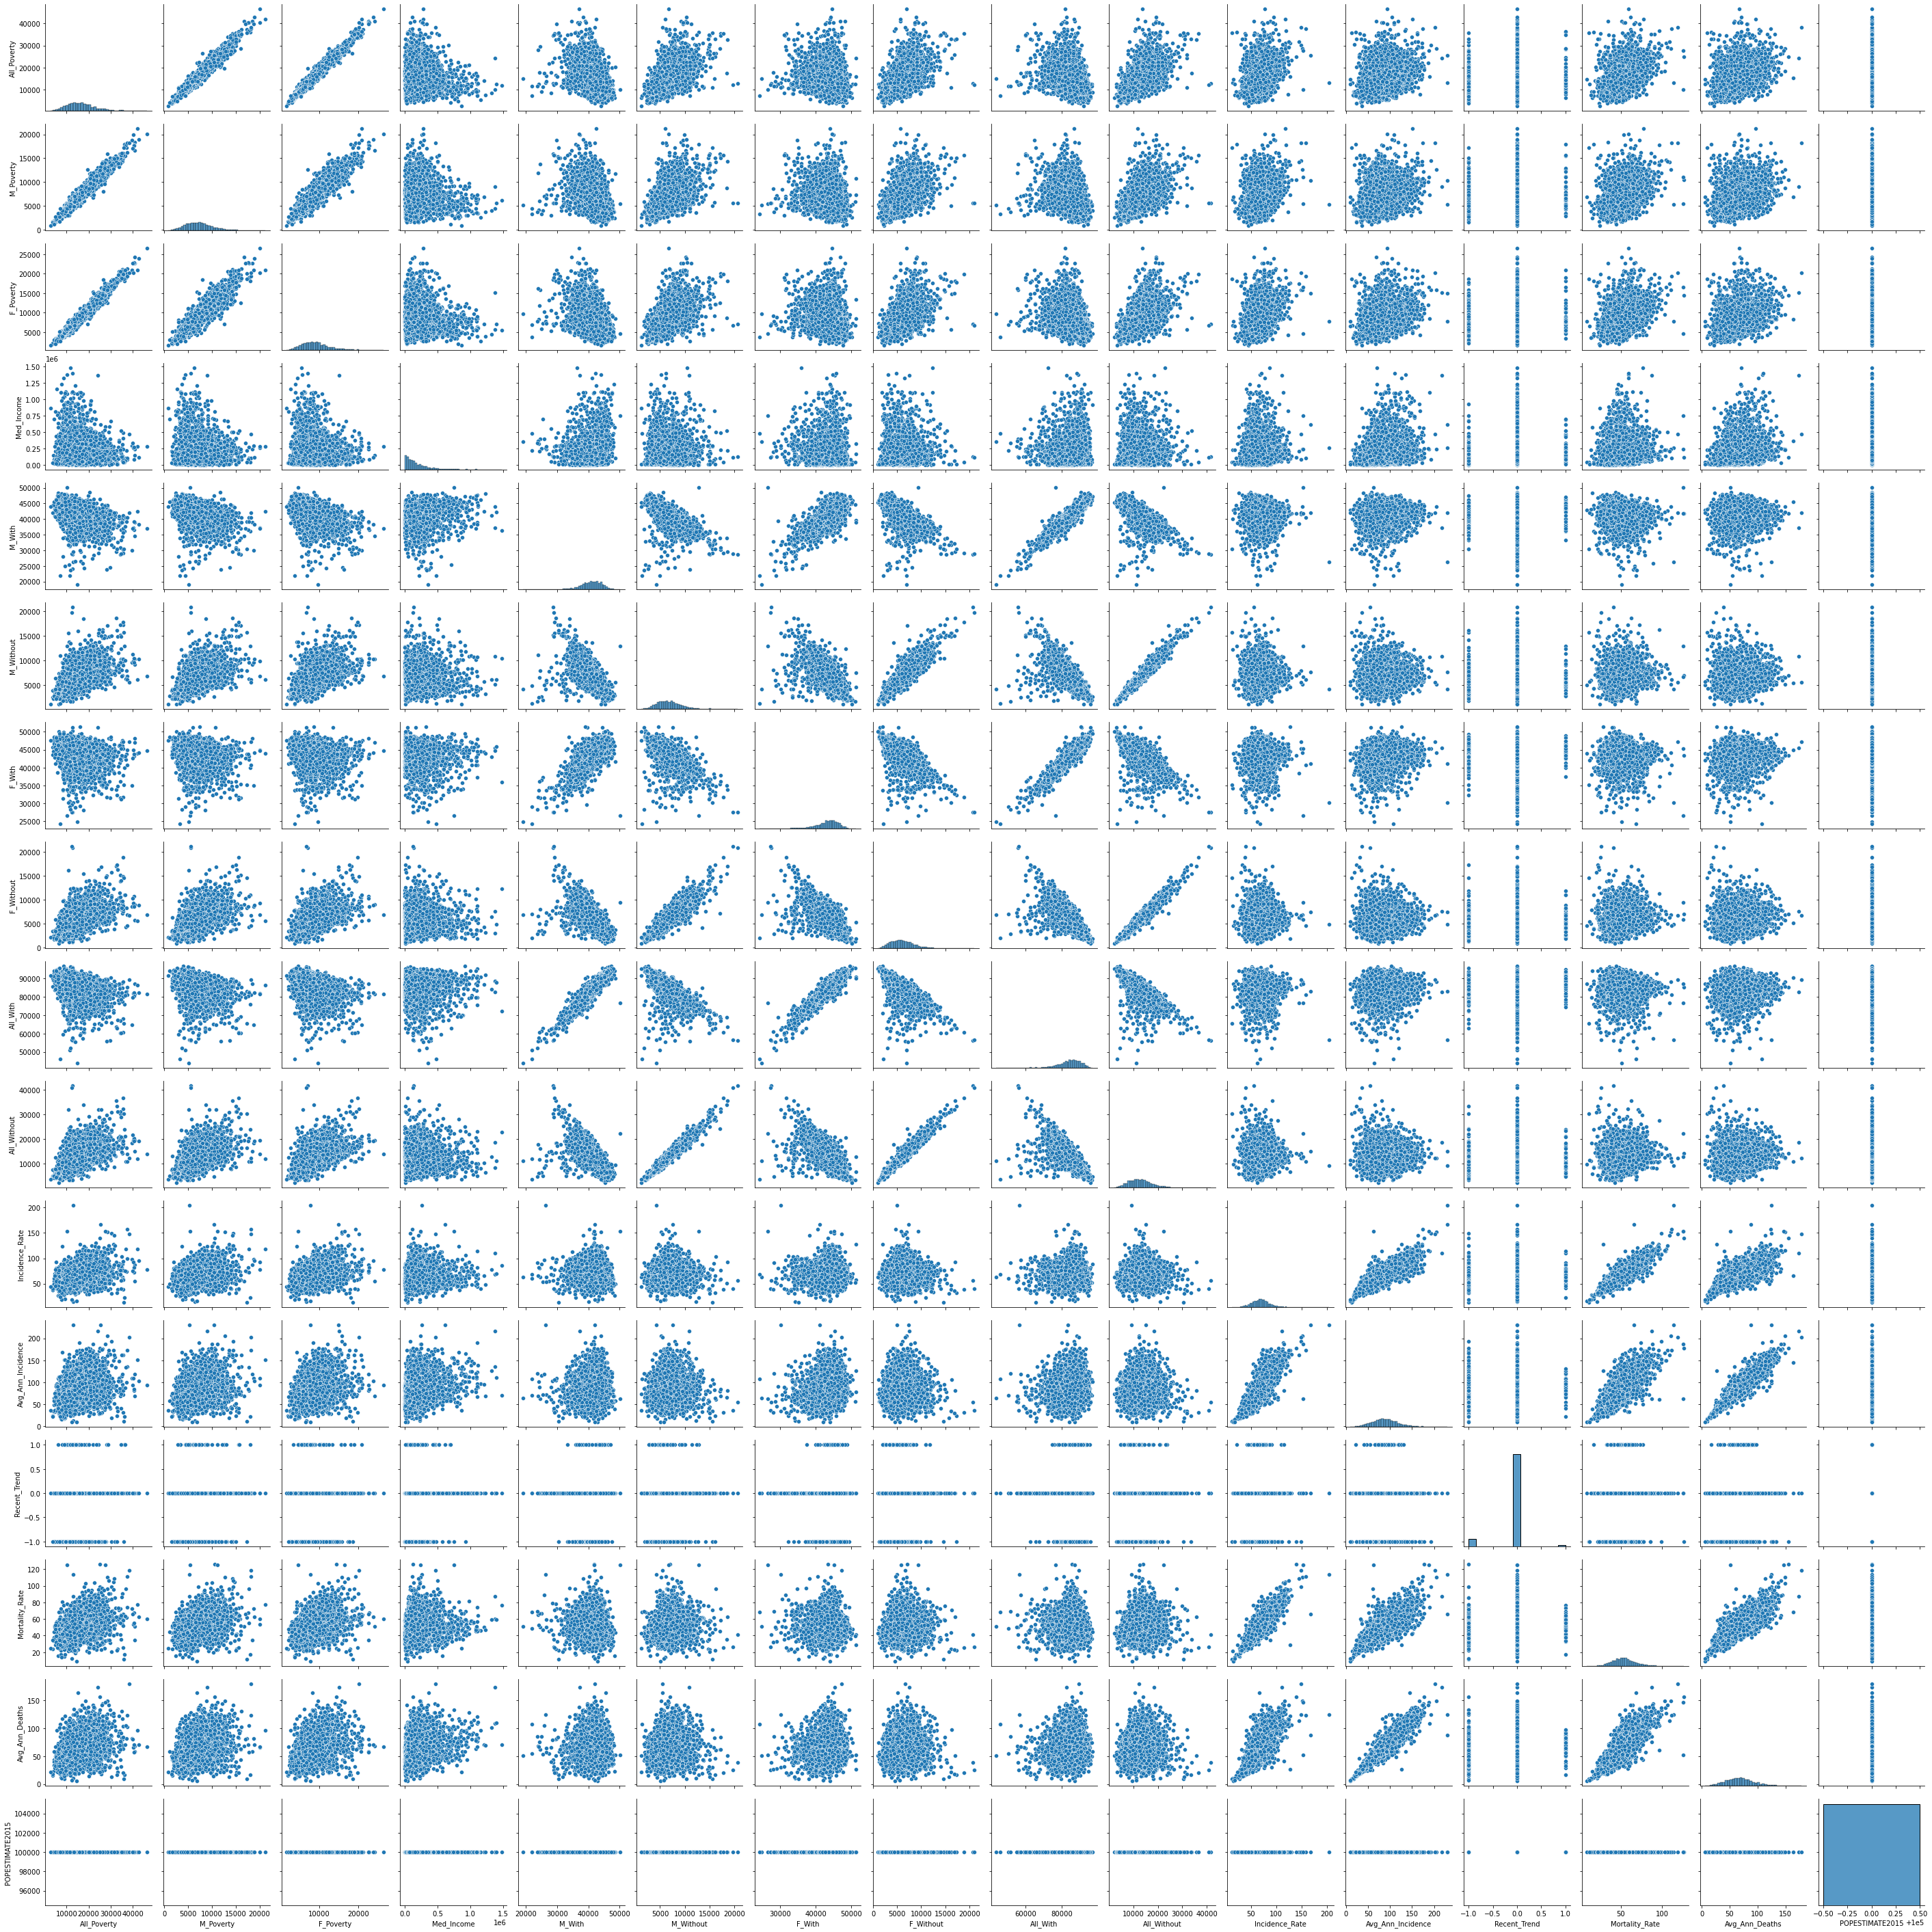

In [37]:
sns.pairplot(percentdf)

### 2.2 Selecting the most important features

In [38]:
corr = percentdf.corr()
corr.style.background_gradient(cmap='coolwarm')

All-NaN slice encountered
All-NaN slice encountered


,All_Poverty,M_Poverty,F_Poverty,Med_Income,M_With,M_Without,F_With,F_Without,All_With,All_Without,Incidence_Rate,Avg_Ann_Incidence,Recent_Trend,Mortality_Rate,Avg_Ann_Deaths,POPESTIMATE2015
All_Poverty,1.000000,0.977424,0.984556,-0.078031,-0.407892,0.547748,-0.203212,0.535482,-0.328820,0.554626,0.328699,0.284926,0.068789,0.387607,0.320510,nan
M_Poverty,0.977424,1.000000,0.925339,-0.077542,-0.370447,0.549749,-0.216938,0.512243,-0.315595,0.543749,0.307363,0.267754,0.066638,0.362074,0.299832,nan
F_Poverty,0.984556,0.925339,1.000000,-0.075771,-0.424989,0.527384,-0.184899,0.536451,-0.328549,0.544698,0.335153,0.289425,0.068221,0.395526,0.326699,nan
Med_Income,-0.078031,-0.077542,-0.075771,1.000000,0.092841,0.036769,-0.117379,0.037142,-0.010865,0.037843,0.002062,0.249956,0.138114,0.042536,0.274744,nan
M_With,-0.407892,-0.370447,-0.424989,0.092841,1.000000,-0.659293,0.750112,-0.663990,0.938093,-0.677539,-0.062958,0.072565,0.008387,-0.099989,0.048288,nan
M_Without,0.547748,0.549749,0.527384,0.036769,-0.659293,1.000000,-0.633355,0.907253,-0.691185,0.976526,0.043377,0.017517,0.014945,0.126599,0.068009,nan
F_With,-0.203212,-0.216938,-0.184899,-0.117379,0.750112,-0.633355,1.000000,-0.685460,0.932742,-0.675257,0.036592,0.134907,-0.034784,-0.021102,0.103013,nan
F_Without,0.535482,0.512243,0.536451,0.037142,-0.663990,0.907253,-0.685460,1.000000,-0.721038,0.976551,0.041195,0.008183,0.030791,0.132367,0.067062,nan
All_With,-0.328820,-0.315595,-0.328549,-0.010865,0.938093,-0.691185,0.932742,-0.721038,1.000000,-0.723080,-0.015158,0.110224,-0.013647,-0.065567,0.080283,nan
All_Without,0.554626,0.543749,0.544698,0.037843,-0.677539,0.976526,-0.675257,0.976551,-0.723080,1.000000,0.043302,0.013158,0.023420,0.132595,0.069158,nan


We decide to drop male below poverty (M_Poverty) and female below poverty (F_Poverty) because they are highly correlated to poverty of all (All_Poverty). Similarly, we drop male without insurance (M_Without) and female without insurance (F_Without) because those are highly correlated with all without insurance (All_Without). We drop male with insurance (M_With) and female with insurance (F_With) because those are highly correlated with all with insurance (All_With).

In [39]:
simpfeatdf = percentdf.copy()
simpfeatdf = simpfeatdf.drop(['M_Poverty','F_Poverty','M_With','F_With','F_Without','M_Without','POPESTIMATE2015'], axis=1)
corr2 = simpfeatdf.corr()
corr2.style.background_gradient(cmap='coolwarm')

,All_Poverty,Med_Income,All_With,All_Without,Incidence_Rate,Avg_Ann_Incidence,Recent_Trend,Mortality_Rate,Avg_Ann_Deaths
All_Poverty,1.000000,-0.078031,-0.328820,0.554626,0.328699,0.284926,0.068789,0.387607,0.320510
Med_Income,-0.078031,1.000000,-0.010865,0.037843,0.002062,0.249956,0.138114,0.042536,0.274744
All_With,-0.328820,-0.010865,1.000000,-0.723080,-0.015158,0.110224,-0.013647,-0.065567,0.080283
All_Without,0.554626,0.037843,-0.723080,1.000000,0.043302,0.013158,0.023420,0.132595,0.069158
Incidence_Rate,0.328699,0.002062,-0.015158,0.043302,1.000000,0.788909,0.065198,0.866994,0.669426
Avg_Ann_Incidence,0.284926,0.249956,0.110224,0.013158,0.788909,1.000000,0.092511,0.719002,0.914501
Recent_Trend,0.068789,0.138114,-0.013647,0.023420,0.065198,0.092511,1.000000,0.062893,0.089621
Mortality_Rate,0.387607,0.042536,-0.065567,0.132595,0.866994,0.719002,0.062893,1.000000,0.797299
Avg_Ann_Deaths,0.320510,0.274744,0.080283,0.069158,0.669426,0.914501,0.089621,0.797299,1.000000


## **Part 3: Regression Model Construction**

### 3.1 Splitting the dataset 

Split the dataset to three parts: train, validation, and test.

Because there are several hyperparameters, the machine learning model requires a large enough validation set to test the model performance based on the training set and large enough hold-out set to test the best model's performance to ensure there is not overfitting/underfitting. Therefore, the ratio is 50:25:25.   

---



In [40]:
#Shuffle data & reset index
simpfeatdf = simpfeatdf.sample(frac=1).reset_index(drop=True)
simpfeatdf.head()

,FIPS,State,AreaName,All_Poverty,Med_Income,All_With,All_Without,Incidence_Rate,Avg_Ann_Incidence,Recent_Trend,Mortality_Rate,Avg_Ann_Deaths
0,13039,GA,"Camden County, Georgia",12216.42,100712.06,79764.69,11982.27,67.4,55.66,0,49.3,40.31
1,26057,MI,"Gratiot County, Michigan",16350.51,100895.52,81803.08,8514.68,66.0,79.44,0,54.1,65.00
2,28039,MS,"George County, Mississippi",17772.64,189355.24,78984.30,17853.93,74.7,81.29,0,76.9,77.01
3,51193,VA,"Westmoreland County, Virginia",13177.15,271773.78,83493.11,15224.91,74.7,124.79,0,52.3,85.09
4,51640,VA,"Galax city, Virginia",25542.38,442638.13,81602.55,13653.46,80.2,115.71,0,36.8,57.85


In [41]:
#Split test (hold-out) dataset
testdf = simpfeatdf[int(0.75*len(simpfeatdf)):len(simpfeatdf)]
print(len(testdf))

661


In [42]:
#Split training & validation dataset
fitdf = simpfeatdf[0:int(0.75*len(simpfeatdf))]
print(len(fitdf))

1980


In [43]:
#Randomize training dataset
np.random.seed(1)
traindf = np.random.choice(fitdf.shape[0], int(2*fitdf.shape[0]/3), replace=False)
print(len(traindf))

1320


In [44]:
# Creating a binary indicator for samples that are selected for training
select = np.in1d(range(fitdf.shape[0]), traindf)
print(select)

[ True  True  True ...  True False False]


### 3.2 Model training 
Create three different models, using different features (and optionally nonlinear transformations). The purpose of these models is to predict mortality rate of lung cancer with reasonably high R2 (at least exceeding 70%) using a carefully chosen and justified set of features. 



---
**1st model:** We start with the features that have the highest correlation with the response variable: number of incidence, without insurance, poverty, and the rate of incidence. We also make sure that those features are not highly correlated to each other to avoid collinearity. For this model, we decide not to include annual cases of deaths because the model might be overfitting (R-square is 0.973 when we include annual number of deaths in this model). 

In [45]:
# Model 1
lm1 = smf.ols('Mortality_Rate~ Incidence_Rate + All_Poverty + Avg_Ann_Incidence + All_Without', data = fitdf[select]).fit()
print(lm1.summary())


                            OLS Regression Results                            
Dep. Variable:         Mortality_Rate   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     1161.
Date:                Fri, 03 Mar 2023   Prob (F-statistic):               0.00
Time:                        20:06:00   Log-Likelihood:                -4361.6
No. Observations:                1320   AIC:                             8733.
Df Residuals:                    1315   BIC:                             8759.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.2052      0.87

**2nd model:** This model is fairly similar to the first model, except that we substitute All_Poverty with Med_Income. The latter feature is fairly intesting because it seems to have a minor degree of polymonial relationship with Mortality_Rate, and slightly skewed in 2.1. Hence, we apply power-transformation to this feature.

In [46]:
# Model 2
lm2 = smf.ols('Mortality_Rate~ Med_Income + I(Med_Income**2) + Incidence_Rate + All_Without + Avg_Ann_Deaths', data = fitdf[select]).fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:         Mortality_Rate   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     1545.
Date:                Fri, 03 Mar 2023   Prob (F-statistic):               0.00
Time:                        20:06:00   Log-Likelihood:                -4086.0
No. Observations:                1320   AIC:                             8184.
Df Residuals:                    1314   BIC:                             8215.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.6830      0

**3rd Model:** This model is also fairly similar to the 1st model. However, we believe Avg_Ann_Incidence might be redundant if there is already Incidence_Rate. Instead, we replace it with Avg_Ann_Deaths, which has a high linear relationship with Mortalitiy Rate.

In [47]:
# Model 3
lm3 = smf.ols('Mortality_Rate~ All_Without  * All_Poverty + Avg_Ann_Deaths + Incidence_Rate', data = fitdf[select]).fit()
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:         Mortality_Rate   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     1494.
Date:                Fri, 03 Mar 2023   Prob (F-statistic):               0.00
Time:                        20:06:00   Log-Likelihood:                -4104.9
No. Observations:                1320   AIC:                             8222.
Df Residuals:                    1314   BIC:                             8253.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

### 3.3 Model selection 
Using different model selection criteria and validation dataset, we choose the single best perfoming model among the three models.

In [48]:
mse_list = []
for model in [lm1, lm2, lm3]:
  preds = model.predict(fitdf)
  square_error= (fitdf['Mortality_Rate'] - preds)**2
  mse = np.mean(square_error[~select])
  mse_list.append(mse)


mod_performance = pd.DataFrame(columns = ['MSE','R2'], index = ['lm1','lm2','lm3'])
mod_performance['MSE'] = mse_list
mod_performance['R2'] = [lm1.rsquared,lm2.rsquared,lm3.rsquared]
print('Model perfromance comparision by validation MSE and R2')
print(mod_performance)

Model perfromance comparision by validation MSE and R2
           MSE        R2
lm1  55.837550  0.779358
lm2  35.394341  0.854667
lm3  36.212748  0.850446


The **model 2** gives us the lowest MSE and highest R-square, so we will choose this one as the best model.

## **Part 4: Model diagnostics**
Explore model collinearity with `variance_inflation_factor`. Larger values of VIF indicate multicollinearity. We the problematic features and refit the model. 

For the chosen model, Avg_Ann_Deaths and Incidence_Rate both have VIF >10. This indicates that these 2 features are highly correlated to each other, thus inflating the performance of the model. This is true to real life context, since death rate is always a portion of incidence rate.

In [49]:
# Model 2
from statsmodels.stats.outliers_influence import variance_inflation_factor

Y = fitdf[['Med_Income','All_Without', 'Avg_Ann_Deaths', 'Incidence_Rate']]
vif_data = pd.DataFrame()
vif_data["feature"] = Y.columns
vif_data["VIF"] = [variance_inflation_factor(Y.values, i)
                          for i in range(len(Y.columns))]

print(vif_data)

          feature        VIF
0      Med_Income   2.157275
1     All_Without   6.044813
2  Avg_Ann_Deaths  18.925083
3  Incidence_Rate  20.503705


Therefore, we decide to drop Incidence_Rate, which has the highest inflation value. The resulting VIF returns to acceptable level (VIF <10).

In [50]:
# Model 2 - Remove Incidence_Rate

Y = fitdf[['Med_Income','All_Without', 'Avg_Ann_Deaths']]
vif_data = pd.DataFrame()
vif_data["feature"] = Y.columns
vif_data["VIF"] = [variance_inflation_factor(Y.values, i)
                          for i in range(len(Y.columns))]

print(vif_data)

          feature       VIF
0      Med_Income  2.077525
1     All_Without  4.860971
2  Avg_Ann_Deaths  5.831367


It is expected that R2 is reduced after dropping Incidence_Rate, because its multicolinearity with Avg_Ann_Deaths inflates the model's variance of regression coefficient.

However, the reduced R2 is still at an acceptable level (R2 > 70%).

In [51]:
# Refit model 2
lm2x = smf.ols('Mortality_Rate~ Med_Income + I(Med_Income**2) +  All_Without + Avg_Ann_Deaths', data = fitdf[select]).fit()
print(lm2x.summary())

                            OLS Regression Results                            
Dep. Variable:         Mortality_Rate   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     704.3
Date:                Fri, 03 Mar 2023   Prob (F-statistic):               0.00
Time:                        20:06:01   Log-Likelihood:                -4603.3
No. Observations:                1320   AIC:                             9217.
Df Residuals:                    1315   BIC:                             9243.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             20.0345      0

## **Part 5: Reporting test performance**
Report the MSE of the final regression model using the test set.

In [52]:
preds2x = lm2x.predict(fitdf)
square_error2x = (fitdf['Mortality_Rate'] - preds2x)**2
mse2x = np.mean(square_error2x[~select])
print('--------Validation MSE for linear regression model--------')
print('MSE:',mse2x)

--------Validation MSE for linear regression model--------
MSE: 72.84259518685755


## **Part 6: Alternative predictive model**

Algorithm for linear regression assumes input features to be mutually independent(no co-linearity). However, there was colinearity in our best performing model. Decision trees handles colinearity better than linear regression, so we will give it a try. 

In [53]:
#Split data
X = percentdf.drop(['Mortality_Rate','FIPS','State','AreaName'], axis=1)
y = percentdf.Mortality_Rate
train_size = 0.5 # we used specific train size before, we can also use a percentage. 
random_state = 0
max_depth = 3

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)

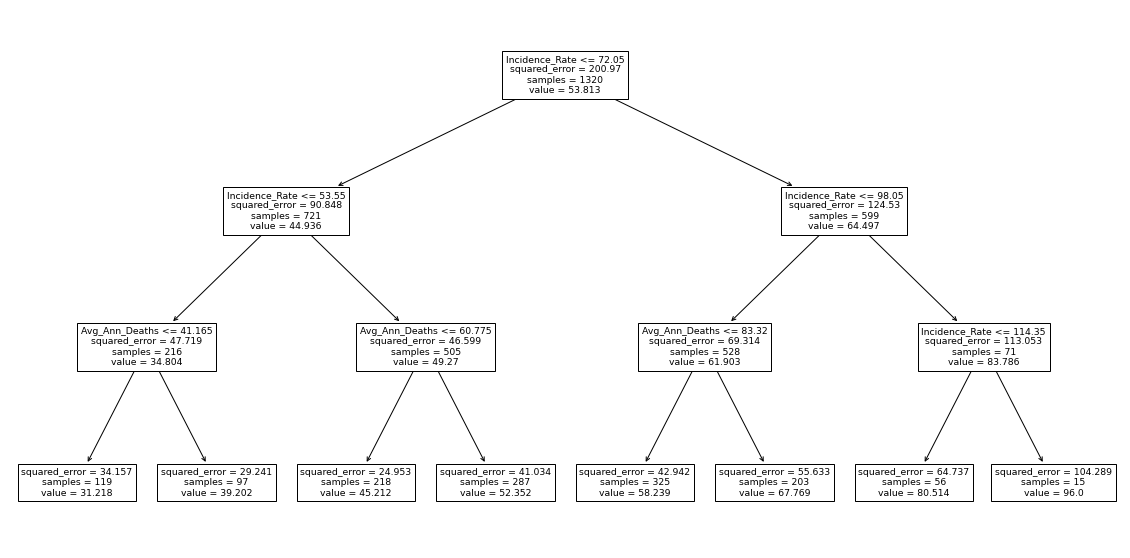

The MSE of Simple tree model is 59.85399507325321


In [54]:
#Fit Simple tree
regr_simple = DecisionTreeRegressor(max_depth=max_depth)
regr_simple.fit(X_train, y_train)
plt.figure(figsize=(20,10)) 
plot_tree(regr_simple, feature_names = X_train.columns)
plt.show()
y_pred_simple = regr_simple.predict(X_test)
mse_simple = mean_squared_error(y_test, y_pred_simple)
print(f'The MSE of Simple tree model is {mse_simple}')

In [55]:
# Fit Bagging tree
all_features = X_train.shape[1]
regr_bag = RandomForestRegressor(max_features=all_features, random_state=4)
regr_bag.fit(X_train, y_train)
y_pred_bag = regr_bag.predict(X_test)
mse_bag = mean_squared_error(y_test, y_pred_bag)
print(f'The MSE of Bagging tree model is {mse_bag}')

The MSE of Bagging tree model is 23.76733832929599


In [56]:
#Fit Random Forest tree
regr_rf = RandomForestRegressor(max_features=3, random_state=1) 
regr_rf.fit(X_train, y_train)

y_pred_rf = regr_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'The MSE of Random Forest tree model is {mse_rf}')

The MSE of Random Forest tree model is 36.452097468584405


In [57]:

mod_performance2 = pd.DataFrame(columns = ['MSE'], index = ['lm2x','regr_simple','regr_bag','regr_rf']) 
mod_performance2['MSE'] = [mse2x, mse_simple,mse_bag,mse_rf]
print('Model perfromance comparision by validation MSE')
print(mod_performance2)

Model perfromance comparision by validation MSE
                   MSE
lm2x         72.842595
regr_simple  59.853995
regr_bag     23.767338
regr_rf      36.452097


Based on the MSE values, **Bagging model** seems to be a better one compared to Model 2, Simple tree and Random Forest tree model. 

Permutation Importance also shows that the Bagging tree also places higher weight for Incidence_rate, Avg_Ann_Deaths, Avg_Ann_Incidence in building the model, similar to the aforementioned linear regression models. However, All_Without is at the lowest levels of importance with this tree model.

In [58]:
perm = PermutationImportance(regr_bag, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
1.0676 ± 0.0509,Incidence_Rate
0.5391 ± 0.0203,Avg_Ann_Deaths
0.1438 ± 0.0070,Avg_Ann_Incidence
0.0139 ± 0.0022,Med_Income
0.0086 ± 0.0014,F_Poverty
0.0040 ± 0.0003,M_Poverty
0.0037 ± 0.0004,All_Poverty
0.0035 ± 0.0003,F_With
0.0035 ± 0.0003,M_Without
0.0034 ± 0.0005,M_With
